In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import torch
import torchaudio
import os.path
from arg_extractor import extract_args_from_json
from experiment_builder import VQVAEExperimentBuilder
from model_architectures import VQVAEQuantizedInput, VQVAE
from vctk_preprocessor import read_audio
import torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [2]:
args = extract_args_from_json('experiment_configs/vqvae_lr1e-2_latents256.json')
args.continue_from_epoch = 0
args.eval_out_path='audio_out'


args.eval_audio_path = 'data/VCTK-Corpus/wav48/p265/p265_075.wav' 

In [3]:
args.num_input_quantization_channels

256

In [4]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)

mulaw = transforms.MuLawEncoding(quantization_channels=args.num_input_quantization_channels)
mulaw_expanding = transforms.MuLawExpanding(quantization_channels=args.num_input_quantization_channels)

torch.Size([1, 36925])


[-0.09838867 -0.03399658  0.10269165 ...  0.02957153  0.0262146
  0.02975464]


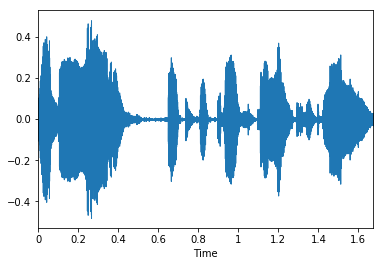

In [5]:
audio = audio.unsqueeze(0)
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)

In [6]:
# Prepare model
vqvae_model = VQVAEQuantizedInput(
    input_shape=(1, 1, args.input_max_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=109, 
    num_input_quantization_channels=args.num_input_quantization_channels)

# Select epoch
epoch = 7

# Load model from state
vqvae_experiment = VQVAEExperimentBuilder(network_model=vqvae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None,
                                    test_data=None,
                                    num_epochs=None)

Building VQVAE.
Building Encoder with 4 downsampling layers.
torch.Size([1, 1, 20000])
torch.Size([1, 16, 6665])
torch.Size([1, 32, 2220])
torch.Size([1, 64, 738])
torch.Size([1, 64, 244])
torch.Size([1, 64, 244])
Building VQ layer.
Building Decoder/Generator with 5 upsampling layers.
torch.Size([1, 64, 244])
torch.Size([1, 64, 730])
torch.Size([1, 64, 2196])
torch.Size([1, 32, 6604])
torch.Size([1, 32, 19903])
torch.Size([1, 32, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 256, 20000])
/Users/simon/mlpcw/experiments/vqvae_lr1e-2_latents256 /Users/simon/mlpcw/experiments/vqvae_lr1e-2_latents256/result_outputs
Loading model train_model, at epoch 7.


In [7]:
args.eval_speaker_id = 1
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [8]:
vqvae_experiment.model.generator.speaker_dict.weight

Parameter containing:
tensor([[ 2.4241e-01,  2.8792e-02,  2.2891e-02, -2.5179e-01,  1.6076e-02,
          1.9857e-01, -9.9423e-02, -5.9750e-02,  8.1929e-02, -3.2602e-01,
         -2.8775e-01,  3.2082e-01, -1.2448e+00,  5.2011e-01,  2.5194e-01,
          7.9388e-01, -2.6480e-01, -1.2622e-01, -1.0790e-01, -5.8360e-02,
         -7.8985e-01,  2.1449e-01,  5.0872e-01,  4.2095e-02,  2.2272e-02,
          2.4348e-01, -2.6664e-01, -2.8551e-01, -4.1163e-01, -1.3780e-01,
         -1.1478e-01,  5.5066e-02, -1.1277e-01,  2.1261e-01,  4.0761e-01,
         -9.9210e-02,  1.9141e-01, -5.1955e-01, -3.4858e-03,  5.0226e-01,
         -3.3119e-01,  1.0787e-02,  1.3197e-01,  1.8149e-01, -5.0428e-01,
          3.9868e-01,  1.1746e-01,  1.2623e-01,  3.2295e-02,  1.5127e-01,
          4.7313e-01,  5.5708e-01, -3.4046e-01,  4.5679e-01, -3.7332e-02,
         -4.1165e-01,  8.7724e-02,  1.6481e-01, -9.3224e-01,  1.0473e-01,
         -1.0380e-01, -2.4720e-01,  6.0874e-01,  4.9568e-02],
        [-7.6086e-02, -6.506

In [9]:
out_mulaw = vqvae_experiment.convert(x=mulaw(audio), y=speaker_id)

out = mulaw_expanding(out_mulaw).detach()
print(out_mulaw)
print(out.shape)

tensor([[ 85,  73,  73,  73,  85,  85, 192,  73,  73,  73,  73,  76,  76,  76,
          76,  79,  76,  76,  72,  72,  72,  76,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  76,  76,  76,  76,  79,
          85,  85,  85,  85,  85,  85,  61,  61,  61,  61,  61,  61,  85,  85,
          85,  79,  85, 165, 172, 172, 172, 198, 198, 198, 198, 198, 198, 198,
         198, 198, 198, 198, 198, 198, 198,  67,  67,  67,  67,  67,  63,  61,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  59,  59,  59,
          61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
          61,  61,  61,  61,  68,  68,  72,  72,  72, 165, 165, 165, 165, 176,
         180, 182, 185, 185, 185, 189, 189, 191, 195, 195, 198, 198, 203, 203,
         203, 205, 207, 207, 207, 207, 207, 203, 203, 195,  56,  56,  56,  56,
          56,  56,  56,  56,  59,  66,  66,  66, 190, 190, 190, 190, 190, 190,
         190, 190, 186, 185, 185,  66,  66,  61,  59

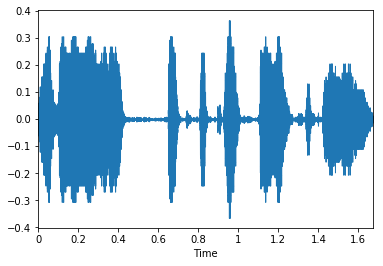

In [10]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [11]:
out.shape

torch.Size([1, 36929])

In [12]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)